<a href="https://colab.research.google.com/github/podobongbong/the_project/blob/main/multi_variable_Resid_backup.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone https://github.com/podobongbong/the_project.git

fatal: destination path 'the_project' already exists and is not an empty directory.


In [2]:
import os
os.chdir('/content/the_project')
import pandas as pd

# Energy Data (2004-2023)
energy_data = pd.read_csv('energy.csv')
energy_data.columns = ['year','city','district','type','jan', 'feb', 'mar', 'apr', 'may', 'jun', 'jul', 'aug', 'sep', 'oct', 'nov', 'dec']

#주택용
energy_data = energy_data[energy_data['type']=='주택용']
monthly_columns = ['jan', 'feb', 'mar', 'apr', 'may', 'jun', 'jul', 'aug', 'sep', 'oct', 'nov', 'dec']
aggregated_data = energy_data.groupby(['year','city'])[monthly_columns].sum().reset_index()

energy_data['city'] = energy_data['city'].replace({'서울특별시': 'seoul', '부산광역시': 'busan'})
aggregated_energy_data = energy_data.groupby(['year', 'city'])[monthly_columns].sum().reset_index()

energy_seoul = aggregated_energy_data[aggregated_energy_data['city'] == 'seoul']
energy_busan = aggregated_energy_data[aggregated_energy_data['city'] == 'busan']


In [3]:
# Population Data (2008-2023)
population_data = pd.read_csv('/content/the_project/population.csv')
population_data.columns = ['year', 'city', 'jan', 'feb', 'mar', 'apr', 'may', 'jun', 'jul', 'aug', 'sep', 'oct', 'nov', 'dec']
population_data['city'] = population_data['city'].replace({'seoul': 'seoul', 'busan': 'busan'})


In [4]:
# Cliamte Data (2004-2023)
climate_busan = pd.read_csv('/content/the_project/climate_busan.csv')
climate_seoul = pd.read_csv('/content/the_project/climate_seoul.csv')
climate_data = pd.concat([climate_busan, climate_seoul], ignore_index=True)
df= climate_data.copy()
df['temp_range'] = df['high'] - df['low']
df['high_deviation'] = df['high'] - df['average']
df['low_deviation'] = df['average'] - df['low']
df = df.dropna()

## Climate feature selection: Primary Component Analysis
from sklearn.decomposition import PCA
import pandas as pd
climate_vars = df[['average', 'low', 'high', 'temp_range','high_deviation','low_deviation']]
climate_vars = climate_vars.dropna()

## Apply PCA to reduce to 1 or 2 components
pca = PCA(n_components=1)  # Adjust to 1 or 2 based on analysis
climate_pca = pca.fit_transform(climate_vars)
df['climate_summary'] = climate_pca[:, 0]  # Only the first component
df['city'] = df['station'].replace({108: 'seoul', 159: 'busan'})

climate_data = df[['ym','city','climate_summary']]
climate_data_seoul = climate_data[climate_data['city']=='seoul']['climate_summary'].values.flatten()
climate_data_busan = climate_data[climate_data['city']=='busan']['climate_summary'].values.flatten()


In [5]:
# Aggregate enery, population, climate data

seoul_data = pd.merge(energy_seoul, population_data, on=['year', 'city'], suffixes=('_energy', '_population'))
busan_data = pd.merge(energy_busan, population_data, on=['year', 'city'], suffixes=('_energy', '_population'))
climate_data_seoul = climate_data[climate_data['city']=='seoul']['climate_summary'].values.flatten()
climate_data_busan = climate_data[climate_data['city']=='busan']['climate_summary'].values.flatten()


In [6]:
#%% DATA PREP
import numpy as np
from sklearn.preprocessing import MinMaxScaler
scaler_energy_seoul = MinMaxScaler()
scaler_population_seoul = MinMaxScaler()
scaler_climate_seoul = MinMaxScaler()

scaler_energy_busan = MinMaxScaler()
scaler_population_busan = MinMaxScaler()
scaler_climate_busan = MinMaxScaler()


# Normalize Seoul data (energy and population)
seoul_energy_scaled = scaler_energy_seoul.fit_transform(seoul_data.filter(like='_energy').values.flatten().reshape(-1, 1))
seoul_population_scaled = scaler_population_seoul.fit_transform(seoul_data.filter(like='_population').values.flatten().reshape(-1, 1))
seoul_climate_scaled = scaler_climate_seoul.fit_transform(climate_data[climate_data['city']=='seoul']['climate_summary'].values.flatten().reshape(-1, 1))

# Normalize Busan data (energy and population)
busan_energy_scaled = scaler_energy_busan.fit_transform(busan_data.filter(like='_energy').values.flatten().reshape(-1, 1))
busan_population_scaled = scaler_population_busan.fit_transform(busan_data.filter(like='_population').values.flatten().reshape(-1, 1))
busan_climate_scaled = scaler_climate_busan.fit_transform(climate_data[climate_data['city']=='busan']['climate_summary'].values.flatten().reshape(-1, 1))

## climate data from 2008
seoul_climate_scaled = seoul_climate_scaled[48:]
busan_climate_scaled = busan_climate_scaled[48:]


In [7]:
#%% SLIDING WINDOW
#%% Create Sliding Windows
def create_sliding_window_multi(data_energy, data_population, data_climate, window_size):
    X, y = [], []
    for i in range(window_size, len(data_energy)):
        X.append(np.column_stack((data_energy[i-window_size:i], data_population[i-window_size:i],data_climate[i-window_size:i])))
        y.append(data_energy[i])  # Next month's energy consumption
    return np.array(X), np.array(y)

WINDOW_SIZE = 12
feature_number = 3 #energy, population, climate

# Create sliding window samples for Seoul and Busan
X_seoul, y_seoul = create_sliding_window_multi(seoul_energy_scaled, seoul_population_scaled, seoul_climate_scaled, WINDOW_SIZE)
X_busan, y_busan = create_sliding_window_multi(busan_energy_scaled, busan_population_scaled, busan_climate_scaled, WINDOW_SIZE)

# Split Busan data into training and test sets (hold out the last 12 months for testing)
X_train_busan = X_busan[:-12]
y_train_busan = y_busan[:-12]
X_test_busan = X_busan[-12:]
y_test_busan = y_busan[-12:]


Pretraining on Seoul's data...
Epoch 1/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 9s 195ms/step - loss: 0.0624 - mae: 0.2029 - val_loss: 0.0725 - val_mae: 0.1667
Epoch 2/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0268 - mae: 0.1381 - val_loss: 0.1012 - val_mae: 0.2205
Epoch 3/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0294 - mae: 0.1063 - val_loss: 0.0808 - val_mae: 0.1782
Epoch 4/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 112ms/step - loss: 0.0171 - mae: 0.0955 - val_loss: 0.0683 - val_mae: 0.1605
Epoch 5/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step - loss: 0.0160 - mae: 0.0943 - val_loss: 0.0696 - val_mae: 0.1622
Epoch 6/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - loss: 0.0246 - mae: 0.1009 - val_loss: 0.0628 - val_mae: 0.1562
Epoch 7/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 116ms/step - loss: 0.0146 - mae: 0.0868 - val_loss: 0.0617 - val_mae: 0.1556
Epoch 8/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 0.0160 - mae: 0.0904 - val_loss: 0.0580 - val_mae: 0.1565
Epoch 9/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0

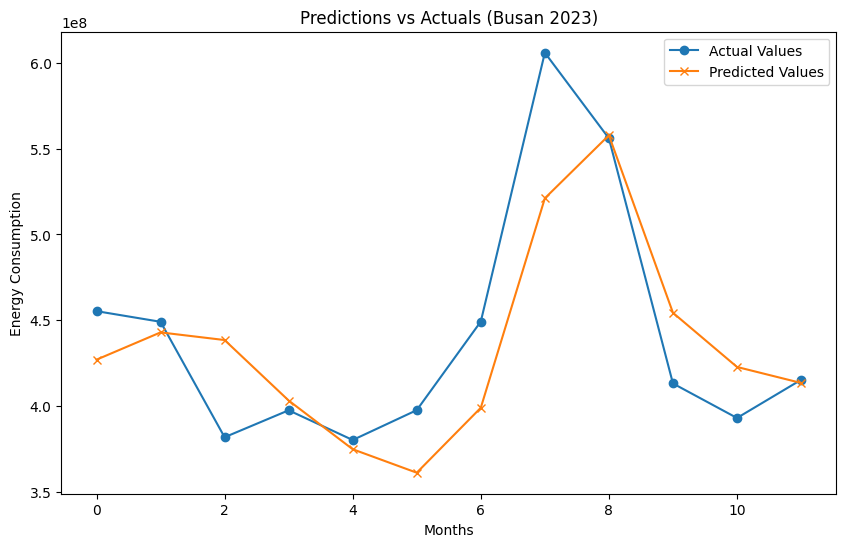

In [8]:
# 2. Feature extraction fine tuning
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Flatten
import matplotlib.pyplot as plt

def build_pretrained_model(window_size, num_features):
    input_layer = Input(shape=(window_size, num_features), name='Input')
    lstm_out = LSTM(64, activation='tanh', name='LSTM_Layer')(input_layer)
    output_layer = Dense(1, activation='linear', name='Output')(lstm_out)

    model = Model(inputs=input_layer, outputs=output_layer)
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    return model

# Pretrain the model on Seoul's data
print("Pretraining on Seoul's data...")
pretrained_model = build_pretrained_model(WINDOW_SIZE, feature_number)
history_pretrain = pretrained_model.fit(X_seoul, y_seoul, epochs=100, batch_size=16, validation_split=0.2)

#%% Feature Extraction with the Pre-trained Model
# Freeze the LSTM layer so it acts as a feature extractor
pretrained_model.get_layer('LSTM_Layer').trainable = False

# Remove the output layer and use the LSTM's output as features
feature_extractor = Model(inputs=pretrained_model.input, outputs=pretrained_model.get_layer('LSTM_Layer').output)

# Generate features for Busan's data
X_train_features_busan = feature_extractor.predict(X_train_busan)
X_test_features_busan = feature_extractor.predict(X_test_busan)

#%% Build a New Model for Busan's Task
def build_new_model_for_finetuning(input_shape):
    input_layer = Input(shape=input_shape, name='Input_Features')
    dense_1 = Dense(32, activation='relu', name='Dense_New_1')(input_layer)
    dense_2 = Dense(16, activation='relu', name='Dense_New_2')(dense_1)
    output_layer = Dense(1, activation='linear', name='Output')(dense_2)

    model = Model(inputs=input_layer, outputs=output_layer)
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    return model

# Create a new model that takes the extracted features as input
new_model = build_new_model_for_finetuning(X_train_features_busan.shape[1:])

# Train the new model on Busan's data
print("Training new layers on Busan's data...")
history_finetune = new_model.fit(X_train_features_busan, y_train_busan, epochs=100, batch_size=32, validation_split=0.2)

#%% Evaluate and Predict on Test Data
print("Evaluating on Busan's test data...")
test_loss, test_mae = new_model.evaluate(X_test_features_busan, y_test_busan)
print(f"Test Loss: {test_loss}, Test MAE: {test_mae}")

# Predict on test data
predictions = new_model.predict(X_test_features_busan)

# Rescale predictions and actual values back to original scale
predictions_rescaled = scaler_energy_busan.inverse_transform(predictions.reshape(-1, 1)).flatten()
actual_rescaled = scaler_energy_busan.inverse_transform(y_test_busan.reshape(-1, 1)).flatten()

#%% Visualization
def plot_predictions(y_true, y_pred, title='Predictions vs Actuals (Busan 2023)'):
    plt.figure(figsize=(10, 6))
    plt.plot(y_true, label='Actual Values', marker='o')
    plt.plot(y_pred, label='Predicted Values', marker='x')
    plt.title(title)
    plt.xlabel('Months')
    plt.ylabel('Energy Consumption')
    plt.legend()
    plt.show()

# Visualize results
plot_predictions(actual_rescaled, predictions_rescaled)


Pretraining on Seoul's data...


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ Input (InputLayer)                   │ (None, 12, 3)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ LSTM_Layer (LSTM)                    │ (None, 64)                  │          17,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Dense_1 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Dense_2 (Dense)                      │ (None, 16)                  │             528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Output (Dense)                       │ (None, 1)                   │              17 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 20,033 (78.25 KB)

 Trainable params: 2,625 (10.25 KB)

 Non-trainable params: 17,408 (68.00 KB)

Epoch 1/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 143ms/step - loss: 0.0229 - mae: 0.1013 - val_loss: 0.0763 - val_mae: 0.1762
Epoch 2/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0175 - mae: 0.1004 - val_loss: 0.0696 - val_mae: 0.1665
Epoch 3/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0181 - mae: 0.1019 - val_loss: 0.0669 - val_mae: 0.1636
Epoch 4/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0236 - mae: 0.1066 - val_loss: 0.0603 - val_mae: 0.1582
Epoch 5/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0186 - mae: 0.0994 - val_loss: 0.0603 - val_mae: 0.1579
Epoch 6/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0143 - mae: 0.0866 - val_loss: 0.0586 - val_mae: 0.1571
Epoch 7/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0225 - mae: 0.1056 - val_loss: 0.0555 - val_mae: 0.1565
Epoch 8/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0169 - mae: 0.0900 - val_loss: 0.0592 - val_mae: 0.1574
Epoch 9/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0205 - mae: 0.1002 

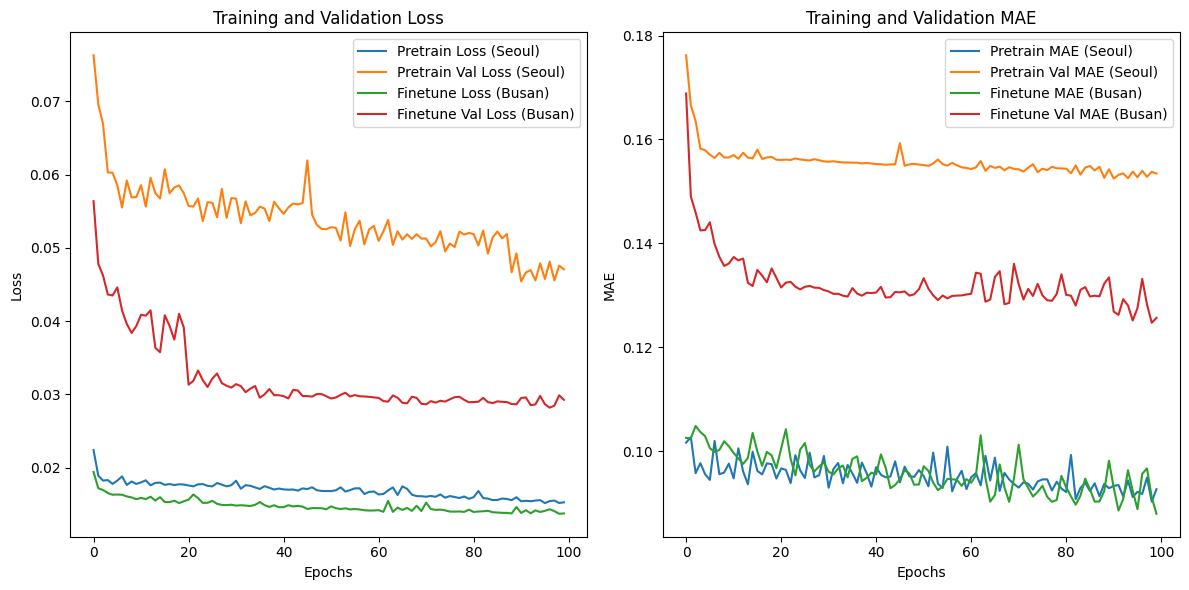

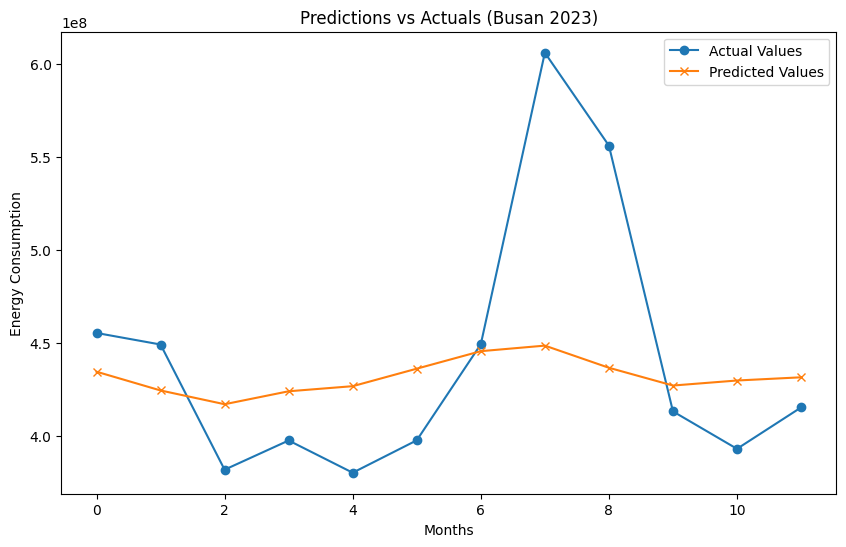

In [9]:

# 1. Partial fine tuning model creation
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense
import matplotlib.pyplot as plt

def build_model_partial_finetune(window_size, num_features):
    input_layer = Input(shape=(window_size, num_features), name='Input')

    # LSTM Layer (pretrained, frozen for fine-tuning)
    lstm_out = LSTM(64, activation='tanh', name='LSTM_Layer')(input_layer)

    # Dense layers (trainable)
    dense_1 = Dense(32, activation='relu', name='Dense_1')(lstm_out)
    dense_2 = Dense(16, activation='relu', name='Dense_2')(dense_1)

    # Output layer for predicting the next month's energy consumption
    output_layer = Dense(1, activation='linear', name='Output')(dense_2)

    # Create the model
    model = Model(inputs=input_layer, outputs=output_layer)

    # Freeze the LSTM layer for fine-tuning (Only dense layers are trainable)
    model.get_layer('LSTM_Layer').trainable = False

    # Compile the model
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])

    return model
# Pretrain on Seoul's data (2008-2023)
print("Pretraining on Seoul's data...")
model = build_model_partial_finetune(WINDOW_SIZE, feature_number)
model.summary()
history_pretrain = model.fit(X_seoul, y_seoul, epochs=100, batch_size=16, validation_split=0.2)

# Fine-tune on Busan's data (Only dense layers are trainable)
print("Fine-tuning on Busan's data...")
history_finetune = model.fit(X_train_busan, y_train_busan, epochs=100, batch_size=32, validation_split=0.2)

#%% Evaluate on Busan's Test Data
print("Evaluating on Busan's test data...")
test_loss, test_mae = model.evaluate(X_test_busan, y_test_busan)
print(f"Test Loss: {test_loss}, Test MAE: {test_mae}")

# Predict on test data
predictions = model.predict(X_test_busan)

# Rescale predictions and actual values back to original scale
predictions_rescaled = scaler_energy_busan.inverse_transform(predictions.reshape(-1, 1)).flatten()
actual_rescaled = scaler_energy_busan.inverse_transform(y_test_busan.reshape(-1, 1)).flatten()

#%% Visualize the Results
# Plot training and validation loss during pretraining and fine-tuning
def plot_training_history(history_pretrain, history_finetune):
    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.plot(history_pretrain.history['loss'], label='Pretrain Loss (Seoul)')
    plt.plot(history_pretrain.history['val_loss'], label='Pretrain Val Loss (Seoul)')
    plt.plot(history_finetune.history['loss'], label='Finetune Loss (Busan)')
    plt.plot(history_finetune.history['val_loss'], label='Finetune Val Loss (Busan)')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history_pretrain.history['mae'], label='Pretrain MAE (Seoul)')
    plt.plot(history_pretrain.history['val_mae'], label='Pretrain Val MAE (Seoul)')
    plt.plot(history_finetune.history['mae'], label='Finetune MAE (Busan)')
    plt.plot(history_finetune.history['val_mae'], label='Finetune Val MAE (Busan)')
    plt.title('Training and Validation MAE')
    plt.xlabel('Epochs')
    plt.ylabel('MAE')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Plot predictions vs actual values for Busan (2023)
def plot_predictions(y_true, y_pred, title='Predictions vs Actuals (Busan 2023)'):
    plt.figure(figsize=(10, 6))
    plt.plot(y_true, label='Actual Values', marker='o')
    plt.plot(y_pred, label='Predicted Values', marker='x')
    plt.title(title)
    plt.xlabel('Months')
    plt.ylabel('Energy Consumption')
    plt.legend()
    plt.show()

# Visualize results
plot_training_history(history_pretrain, history_finetune)
plot_predictions(actual_rescaled, predictions_rescaled)


Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ Input (InputLayer)                   │ (None, 12, 3)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ LSTM_Layer (LSTM)                    │ (None, 64)                  │          17,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Dense_1 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Dense_2 (Dense)                      │ (None, 16)                  │             528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Output (Dense)                       │ (None, 1)                   │              17 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 20,033 (78.25 KB)

 Trainable params: 20,033 (78.25 KB)

 Non-trainable params: 0 (0.00 B)

Pretraining on Seoul data (2008-2023)...
Epoch 1/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 38ms/step - loss: 0.0357 - mae: 0.1326 - val_loss: 0.0707 - val_mae: 0.1723
Epoch 2/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0210 - mae: 0.1044 - val_loss: 0.0682 - val_mae: 0.1677
Epoch 3/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 103ms/step - loss: 0.0163 - mae: 0.0917 - val_loss: 0.0724 - val_mae: 0.1774
Epoch 4/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0114 - mae: 0.0781 - val_loss: 0.0642 - val_mae: 0.1602
Epoch 5/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0145 - mae: 0.0915 - val_loss: 0.0598 - val_mae: 0.1530
Epoch 6/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0163 - mae: 0.0948 - val_loss: 0.0585 - val_mae: 0.1517
Epoch 7/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0145 - mae: 0.0933 - val_loss: 0.0593 - val_mae: 0.1529
Epoch 8/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0150 - mae: 0.0897 - val_loss: 0.0541 - val_mae: 0.1471
Epoch 9/100
8/8 ━━━━━━━━━━━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step
Predictions for Busan (2023): [4.1225888e+08 4.7171536e+08 3.6736330e+08 3.5186314e+08 3.5842467e+08
 3.8150435e+08 4.7440838e+08 7.0940186e+08 4.5855744e+08 3.4881472e+08
 3.5554550e+08 3.7440086e+08]
Actual values for Busan (2023): [4.55234652e+08 4.49022726e+08 3.81679164e+08 3.97397758e+08
 3.80056494e+08 3.97485280e+08 4.49167246e+08 6.05983897e+08
 5.56022160e+08 4.13041954e+08 3.92909079e+08 4.15166775e+08]


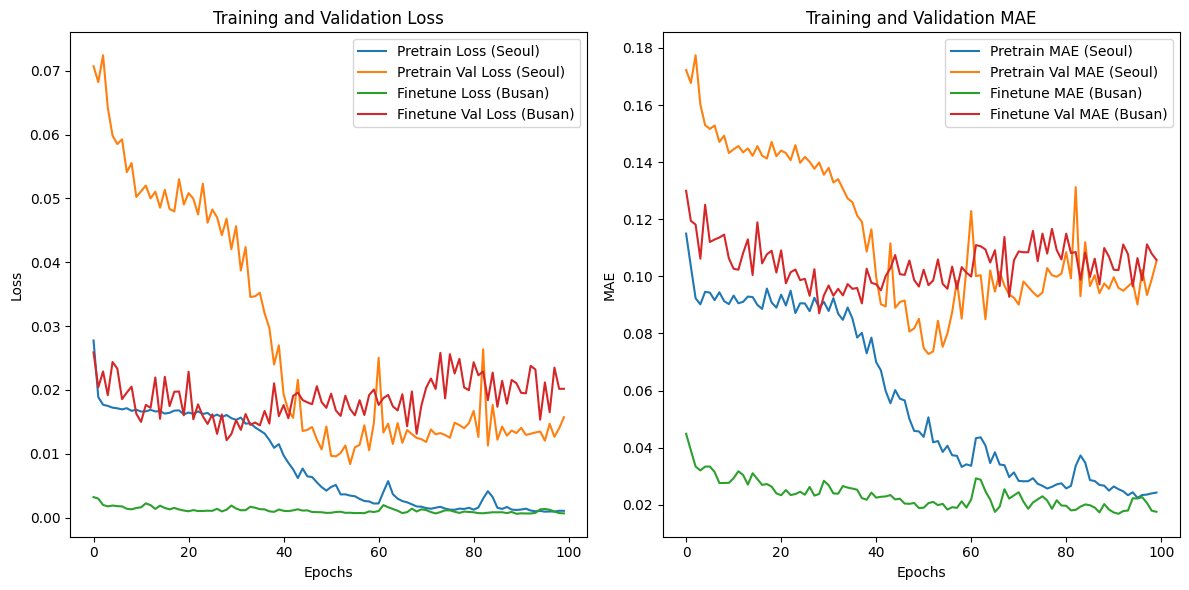

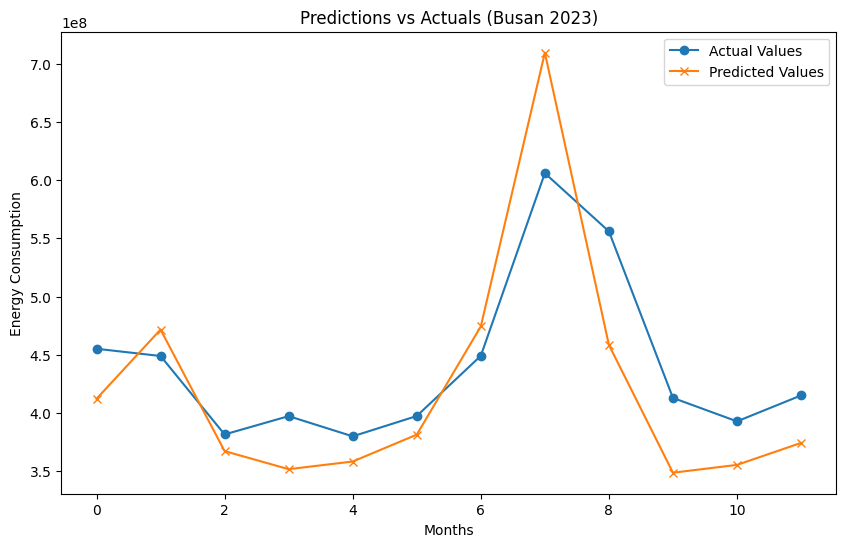

In [10]:
# 0. Full fine-tune multi variable Model
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Reshape # Import Reshape

# Define the LSTM model structure
def build_model(window_size, num_features): # Add num_features
    input_layer = Input(shape=(window_size, num_features), name='Input') # Update input shape
    # Reshape is no longer needed since the input shape is already 3D
    # reshaped_input = Reshape((window_size, 1))(input_layer)
    lstm_out = LSTM(64, activation='tanh', name='LSTM_Layer')(input_layer)

    # Dense layers for final prediction
    dense_1 = Dense(32, activation='relu', name='Dense_1')(lstm_out)
    dense_2 = Dense(16, activation='relu', name='Dense_2')(dense_1)

    # Output layer for predicting the next month's energy consumption
    output_layer = Dense(1, activation='linear', name='Output')(dense_2)

    # Create the model
    model = Model(inputs=input_layer, outputs=output_layer)

    # Compile the model
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])

    return model

# Create the LSTM model, specifying the number of features
model = build_model(WINDOW_SIZE, feature_number)

# Print model summary
model.summary()

print("Pretraining on Seoul data (2008-2023)...")
history_pretrain = model.fit(X_seoul, y_seoul, epochs=100, batch_size=16, validation_split=0.3)

# Fine-tune the model on Busan's data (train on 2008-2022)
print("Fine-tuning on Busan data (2008-2022)...")
history_finetune = model.fit(X_train_busan, y_train_busan, epochs=100, batch_size=16, validation_split=0.3)

# Test the model on Busan's test data (2023)
print("Testing on Busan data (2023)...")
test_loss, test_mae = model.evaluate(X_test_busan, y_test_busan)
print(f"Test Loss: {test_loss}, Test MAE: {test_mae}")

# Predict on the test data
predictions = model.predict(X_test_busan)

# Rescale predictions back to the original Busan scale using the Busan-specific scaler
predictions_rescaled = scaler_energy_busan.inverse_transform(predictions.reshape(-1, 1)).flatten()

# Display the rescaled predictions
print("Predictions for Busan (2023):", predictions_rescaled)

# Also compare the rescaled predictions with the actual values
actual_rescaled = scaler_energy_busan.inverse_transform(y_test_busan.reshape(-1, 1)).flatten()
print("Actual values for Busan (2023):", actual_rescaled)

import matplotlib.pyplot as plt

# 1. Plot training and validation loss during pretraining and fine-tuning
def plot_training_history(history_pretrain, history_finetune):
    plt.figure(figsize=(12, 6))

    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(history_pretrain.history['loss'], label='Pretrain Loss (Seoul)')
    plt.plot(history_pretrain.history['val_loss'], label='Pretrain Val Loss (Seoul)')
    plt.plot(history_finetune.history['loss'], label='Finetune Loss (Busan)')
    plt.plot(history_finetune.history['val_loss'], label='Finetune Val Loss (Busan)')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Plot MAE
    plt.subplot(1, 2, 2)
    plt.plot(history_pretrain.history['mae'], label='Pretrain MAE (Seoul)')
    plt.plot(history_pretrain.history['val_mae'], label='Pretrain Val MAE (Seoul)')
    plt.plot(history_finetune.history['mae'], label='Finetune MAE (Busan)')
    plt.plot(history_finetune.history['val_mae'], label='Finetune Val MAE (Busan)')
    plt.title('Training and Validation MAE')
    plt.xlabel('Epochs')
    plt.ylabel('MAE')
    plt.legend()

    plt.tight_layout()
    plt.show()

# 2. Plot predictions vs actual values for Busan (2023)
def plot_predictions(y_true, y_pred, title='Predictions vs Actuals (Busan 2023)'):
    plt.figure(figsize=(10, 6))
    plt.plot(y_true, label='Actual Values', marker='o')
    plt.plot(y_pred, label='Predicted Values', marker='x')
    plt.title(title)
    plt.xlabel('Months')
    plt.ylabel('Energy Consumption')
    plt.legend()
    plt.show()

# Call the functions to visualize training and results
plot_training_history(history_pretrain, history_finetune)
plot_predictions(actual_rescaled, predictions_rescaled)

